<a id="toc"></a>
# **S4E2: Obesity Classification w/ LightGBM**

Table of Contents:
* [About the Project](#1)
* [About the Data](#2)
* [Set Up](#3)
* [Exploratory Data Analysis](#4)
    - [Train Dataset](#4a)
    - [Original Dataset](#4b)
    - [Categorical Predictors & Target Variable](#4c)
    - [Numerical Predictors](#4d)
* [Data Preprocessing](#5)
* [Building the Model](#6)
* [Model Evaluation](#7)
* [Kaggle Submission](#8)
* [Conclusion](#9)
* [References](#R)

<a id="1"></a>
# **About the Project**

This project is meant to be completed as part of [Kaggle's Playground Series (Season 4, Episode 2)](https://www.kaggle.com/competitions/playground-series-s4e2/overview) and as a final project for the 'Data Mining Project' course in CU Boulder's MS-DS program. Throughout this project, I have attempted to be as verbose as possible in order to both further my understanding of the tools and methods I am using and to also provide guidance to any interested data scientists.

Obesity is a complex disease that is currently affecting a growing proportion of the global population. According to the [National Library of Medicine](https://pubmed.ncbi.nlm.nih.gov/35584732/), obesity is currently considered to be a global epidemic. Moreover, the [World Obesity Federation](https://www.worldobesity.org/resources/resource-library/world-obesity-atlas-2022) predicts that by 2030, 1 in 5 women and 1 in 7 men will likely have obesity. Due to the fact that this disease may contribute to worsened health, it is imperative to identify its potential causes. One paper, published in *[Nutrients](https://www.mdpi.com/2072-6643/14/20/4253)*, suggests that obesity has a strong association with the consumption of ultra-processed foods, i.e. foods that are high in calories, sugar, salt, and fat.

This project aims to identify significant predictors of obesity and will leverage a LightGBM classifier model to predict the level of obesity (or lack of obesity) in an individual given their predictive characteristics. [LightGBM](https://github.com/microsoft/LightGBM), developed by Microsoft, is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms. This machine learning model can be used for classification, which is the general approach of this project. LightGBM has been selected for this project for its relative speed and accuracy. Furthermore, this project is also intended to be used as an opportunity to learn how to develop and implement this type of tool. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="2"></a>
# **About the Data**

This project utilizes two datasets, i.e. the original data and synthetic data. The first is the dataset provided by [Kaggle](https://www.kaggle.com/competitions/playground-series-s4e2/data). This dataset was generated from a deep learning model trained on the 'Obesity or CVD risk' dataset, originally published by [ARAVINDPCODER](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster). This original dataset includes data that was collected from an anonymous online survey. 

Both datasets include the categorical target variable 'NObeyesdad'. This variable denotes the deduced obesity level for a given individual. The levels of the target variable include:
- **Insufficient_Weight**
- **Normal_Weight**
- **Overweight_Level_I**
- **Overweight_Level_II**
- **Obesity_Type_I**
- **Obesity_Type_II**
- **Obesity_Type_III**

Both datasets also include 16 predictors, some of which are categorical and others are numerical. These predictors include: 
- **Gender**
- **Age**
- **Height**
- **Weight**
- **family_history_with_overweight** (yes/no)
- **FAVC** (frequent consumption of high caloric food, yes/no)
- **FCVC** (frequency of consumption of vegetables)
- **NCP** (number of main meals)
- **CAEC** (consumption of food between meals)
- **SMOKE** (smoker or not, yes/no)
- **CH20** (consumption of water daily)
- **SCC** (monitoring consumption of calories, yes/no)
- **FAF** (physical activity frequency)
- **TUE** (time using technology devices)
- **CALC** (consumption of alcohol) 
- **MTRANS** (transportation used)

The Kaggle dataset includes a 18th column, which provides an 'id' key. This column is mostly used for submission purposes. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="3"></a>
# **Set Up**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier, plot_importance

In [2]:
# Importing the Kaggle datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [3]:
# Importing the original dataset (from ARAVINDPCODER)
original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="4"></a>
# **Exploratory Data Analysis**

In [4]:
# Viewing the shapes of each dataset
print(f'The shape of the train dataset is: {np.shape(train)}')
print(f'The shape of the test dataset is: {np.shape(test)}')
print(f'The shape of the original dataset is: {np.shape(original)}')

The shape of the train dataset is: (20758, 18)
The shape of the test dataset is: (13840, 17)
The shape of the original dataset is: (2111, 17)


Above, we can see the shapes (or dimensions) of the datasets used in this project. To start, the shape of the train dataset is (20758, 18), meaning that there are 20758 entries (or rows) of data and 18 attributes (or columns). As mentioned above, these columns include the target variable, 16 predictors, and the 'id' column. The test data has a similar shape of (13840, 17). Here, we can see that the test dataset includes ~66% of the number of entries as the train dataset. Furthermore, the test dataset only includes 17 columns, as the target variable column has been omitted. Lastly, the shape of the original dataset is (2111, 17). This dataset is obviously much smaller than the train dataset, as it has far fewer entries of data. Furthermore, the original dataset only includes 17 columns, as it does not include the 'id' column. Despite its small size, the original dataset remains useful, as we can combine it with the train dataset to provide our model with more training data. 

<a id="4a"></a>
## **Viewing the 'train' dataset**

In [5]:
# Viewing the first 5 entries of the 'train' dataset
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Above, we can gain a brief understanding of what the train dataset contains and looks like. Here, we can also confirm that this dataset includes the target variable 'NObeyesdad', 16 predictors, and the 'id' column. 

In [6]:
# Viewing basic statistical information of the 'train' dataset
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


Here, we can obtain some basic summary statistics of the train dataset. In the 'count' row, we can verify that each column contains 20758 entries of data. This provides evidence that there is no missing data in this dataset. In the following rows, we obtain further useful information, such as the mean values, standard deviation, minimum and maximum values, and quartiles. At a glance, the minimum and maximum values can help us identify any potential anomalies. For example, if the maximum value of the 'Age' column was 1546, we could deduce that this value is incorrect and likely an error. Fortunately, the minimum and maximum values for 'Age' are 14 and 61, respectively. This provides further evidence of the cleanliness and accuracy of the dataset.  

In [7]:
# Getting more summary statistics of the 'train' dataset
sum_train = pd.DataFrame(index = list(train))
sum_train['Dtype'] = train.dtypes
sum_train['Count'] = train.count()
sum_train['#Unique'] = train.nunique()
sum_train['%Unique'] = sum_train['#Unique'] / len(train) * 100
sum_train['#Null'] = train.isnull().sum()
sum_train['%Null'] = sum_train['#Null'] / len(train) * 100
sum_train

,Dtype,Count,#Unique,%Unique,#Null,%Null
id,int64,20758,20758,100.000000,0,0.0
Gender,object,20758,2,0.009635,0,0.0
Age,float64,20758,1703,8.204066,0,0.0
Height,float64,20758,1833,8.830330,0,0.0
Weight,float64,20758,1979,9.533674,0,0.0
family_history_with_overweight,object,20758,2,0.009635,0,0.0
FAVC,object,20758,2,0.009635,0,0.0
FCVC,float64,20758,934,4.499470,0,0.0
NCP,float64,20758,689,3.319202,0,0.0
CAEC,object,20758,4,0.019270,0,0.0


Above, there are more summary statistics of the train dataset. To start, we can confirm the datatype of each column. At a glance, many of the column datatypes are numerical and are either int64 or float64. The remaining columns are categorical predictors and are object datatypes. It is important to take note of this, as all columns with object datatypes will need to be converted into boolean values using one-hot encoding. This will be done in the Data Preprocessing section of this project. It is imperative to convert these datatypes, as objects with values such as 'Yes' or 'No' will need to be transformed into boolean values, such as '0' or '1', so that the model can leverage these categorical predictors. 

The code chunk above also shows us if there are any null values in the dataset. Fortunately, this dataset has already been cleaned and thus contains no null values. 

<a id="4b"></a>
## **Viewing the 'original' dataset**

In [8]:
# Viewing the first 5 entries of the 'original' dataset
original.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Above, we can see the first five entries in the original dataset. These appear to be similar to the train dataset, as the train dataset was generated from the original dataset. The only difference here is the lack of the 'id' column. 

In [9]:
# Viewing basic statistical information of the 'original' dataset
original.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [10]:
# Getting more summary statistics of the 'original' dataset
sum_original = pd.DataFrame(index = list(original))
sum_original['Dtype'] = original.dtypes
sum_original['Count'] = original.count()
sum_original['#Unique'] = original.nunique()
sum_original['%Unique'] = sum_original['#Unique'] / len(original) * 100
sum_original['#Null'] = original.isnull().sum()
sum_original['%Null'] = sum_original['#Null'] / len(original) * 100
sum_original

,Dtype,Count,#Unique,%Unique,#Null,%Null
Gender,object,2111,2,0.094742,0,0.0
Age,float64,2111,1402,66.414022,0,0.0
Height,float64,2111,1574,74.561819,0,0.0
Weight,float64,2111,1525,72.240644,0,0.0
family_history_with_overweight,object,2111,2,0.094742,0,0.0
FAVC,object,2111,2,0.094742,0,0.0
FCVC,float64,2111,810,38.370441,0,0.0
NCP,float64,2111,635,30.080531,0,0.0
CAEC,object,2111,4,0.189484,0,0.0
SMOKE,object,2111,2,0.094742,0,0.0


Again, the two code chunks above provide us with some basic statistical information of the original dataset. As with the train dataset, this dataset also appears to have clean and accurate data. The only significant difference between the original and train datasets is that the original dataset has far fewer rows of data. 

<a id="4c"></a>
## **Categorical Predictors & Target Variable**

This section aims to visualize the distributions of the eight categorical predictors and the single target variable in the train dataset by using donut charts and bar charts with count values. The categorical predictors and target variable include:

- NObeyesdad
- Gender
- family_history_with_overweight
- FAVC
- CAEC
- SMOKE
- SCC
- CALC
- MTRANS

In [11]:
# Creating 'showplot' function to plot categorical predictors
# Kudos to Dee Dee for this code chunk! 
def showplot(columnname):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = train[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors =["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']
    
    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    # circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    # Count Plot
    sns.countplot(data=train, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9,color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

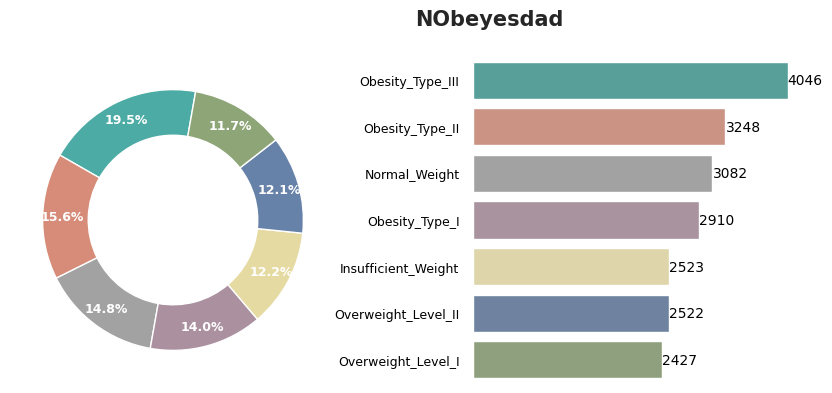

In [12]:
# Visualizing 'NObeyesdad'
showplot("NObeyesdad")

Above, we can see the distribution of classes for the target variable 'NObeyesdad'. This variable has seven different classes, which correspond to an individual's obesity status. At a glance, there appears to be a roughly even distribution of classes. Shockingly, only 14.8% of individuals taking the survey were of normal weight and only 12.2% were underweight ('Insufficient_Weight'). This means that the vast majority (73%) of individuals were AT LEAST overweight ('Overweight_Level_I'). Moreover, almost half (49.1%) of the survey population had some type of obesity. 

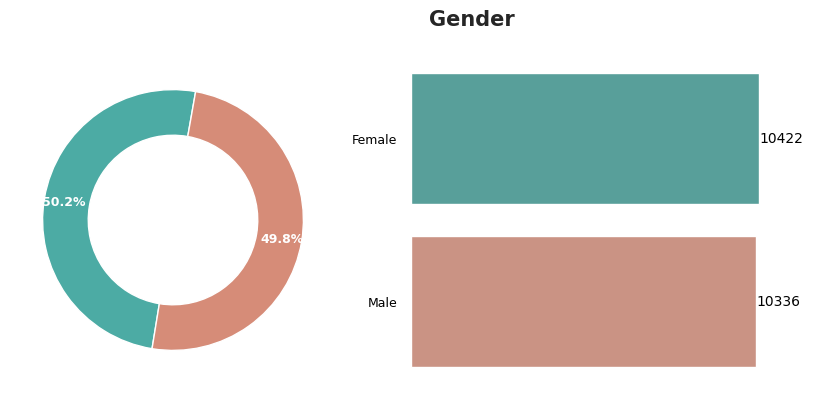

In [13]:
# Visualizing 'Gender'
showplot("Gender")

The plot above shows the distribution of gender. Here, we can see a balanced distribution, as females accounted for 50.2% of the survey and males accounted for 49.8%. 

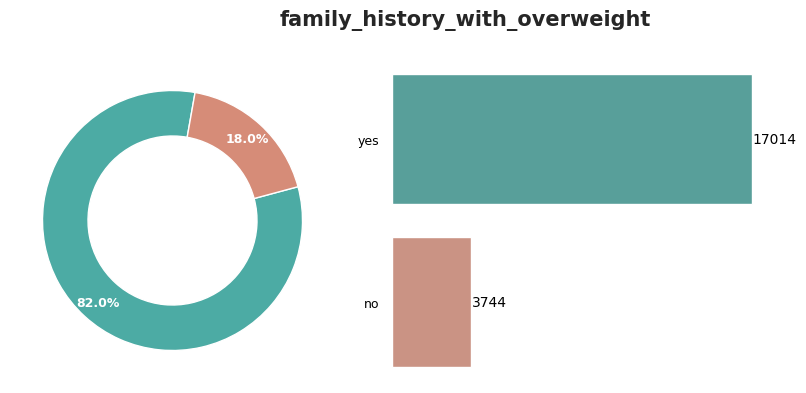

In [14]:
# Visualizing 'family_history_with_overweight'
showplot("family_history_with_overweight")

Above, we can see that the distribution for 'family_history_with_overweight' is imbalanced. The vast majority of individuals (82%) have a family member who suffers or has sufferred from being overweight. This is intriguing, as one could postulate that particular diets or habits passed down through the family could further contribute to overweight/obesity rates of younger family members. 

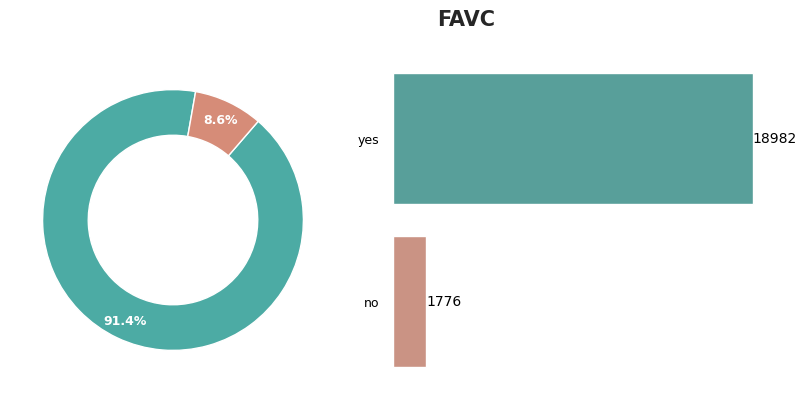

In [15]:
# Visualizing 'FAVC'
showplot("FAVC")

As with 'family_history_with_overweight', 'FAVC' (frequent consumption of high caloric food) shows an imbalanced distribution. Here, roughly 91.4% of individuals have admitted to the frequent consumption of high caloric foods. As briefly discussed in the Introduction section, it is believed that obesity has a strong association with the consumption of ultra-processed foods. From this, we could suggest that the individuals who are frequently consuming high caloric foods may also likely be overweight or obese. 

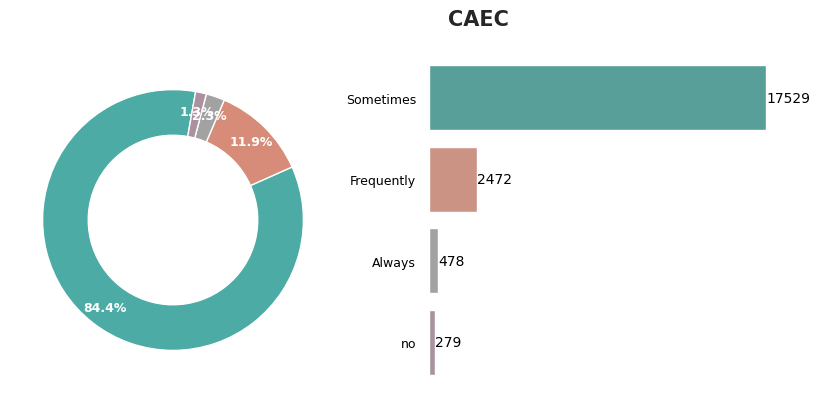

In [16]:
# Visualizing 'CAEC'
showplot("CAEC")

Above, we can see the distribution of 'CAEC', i.e. the consumption of food between meals. This distributuion is also imbalanced, as the majority (84.4%) of individuals reported to eat between meals sometimes. Moreover, a significant minority (1.3%) reported to not eat at all between meals. 

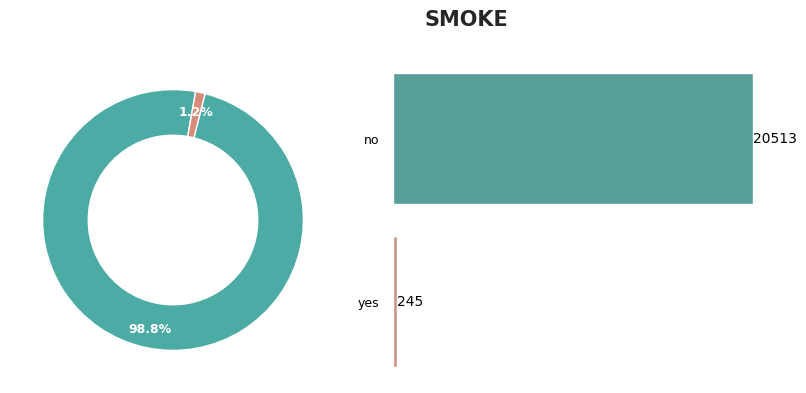

In [17]:
# Visualizing 'SMOKE'
showplot("SMOKE")

Here, we can see that the distribution of 'SMOKE' (smoker or not) is also highly imbalanced. 98.8% of the individuals reported to not smoke. This distribution seems unlikely, as quick research provides us with contradictory evidence. One paper, published in [The Lancet](https://www.thelancet.com/journals/langlo/article/PIIS2214-109X(20)30311-9/fulltext), reports that smoking is a leading risk factor for death and disability in Latin America. Moreover, the paper estimates that smoking is responsible for roughly 12% of total adult deaths. From this, we may argue that it is unlikely that only 1.2% of survey participants are smokers. 

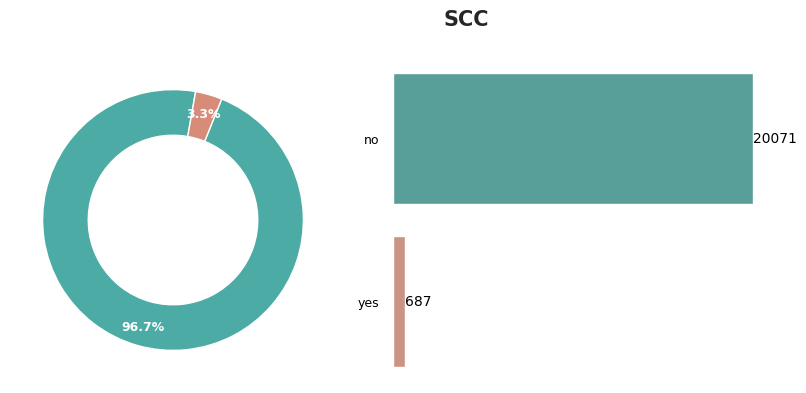

In [18]:
# Visualizing 'SCC'
showplot("SCC")

The plot above shows another imbalanced distribution for 'SCC' (calories consumption monitoring). Here, only 3.3% of individuals reported to monitor their consumption of calories. 

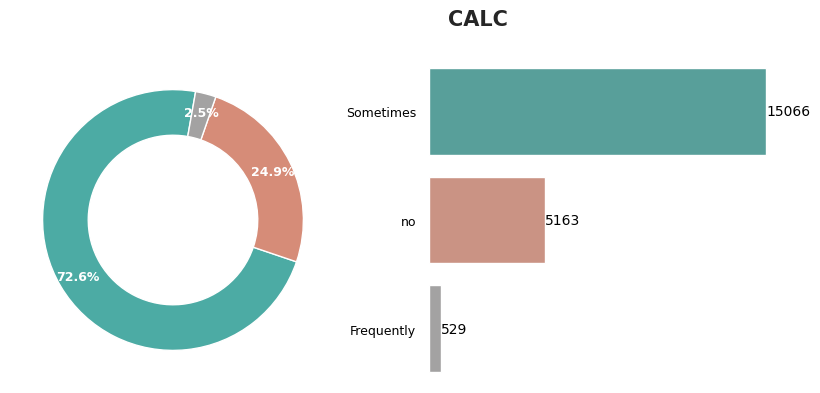

In [19]:
# Visualizing 'CALC'
showplot("CALC")

Above, 'CALC' represents the consumption of alcohol. The majority (72.6%) of individuals reported to consume alcohol sometimes, while 24.9% reported to not drink, and only 2.5% reported to drink frequently. 

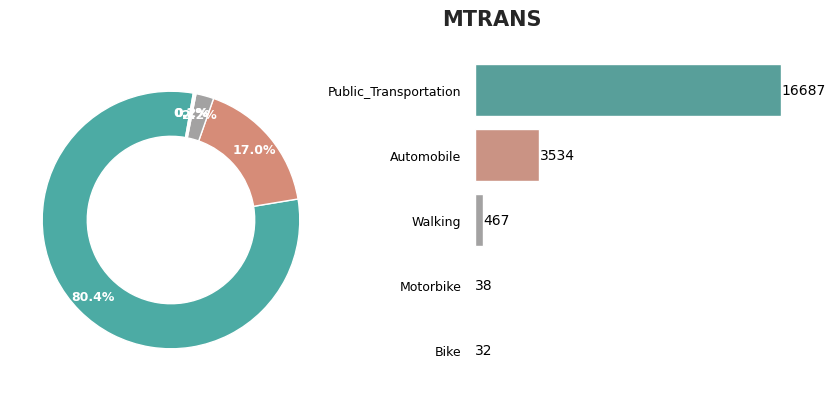

In [20]:
# Visualizing 'MTRANS'
showplot("MTRANS")

The final categorical variable is 'MTRANS', which represents the type of transportation frequently used by a given individual. Here, we can see that the vast majority (80.4%) of individuals rely on public transportation. This accounts for 16687 individuals, which greatly outnumbers the 467 individuals who walk and the 32 individuals who bike. Given the high rates of individuals who are either overweight or obese (shown in NObeyesdad), it is not surprising to see the reliance on public transportation or automobiles. 

<a id="4d"></a>
## **Numerical Predictors**

This section highlights the distributions of each numerical predictor. The distributions are visualized via the use of kernel density estimate plots (similar to histograms). Furthermore, this section leverages a heatmap to examine potential correlations amongst the numerical predictors. The numerical predictors include:

- Age
- Height
- Weight
- FCVC
- NCP
- CH20
- FAF
- TUE

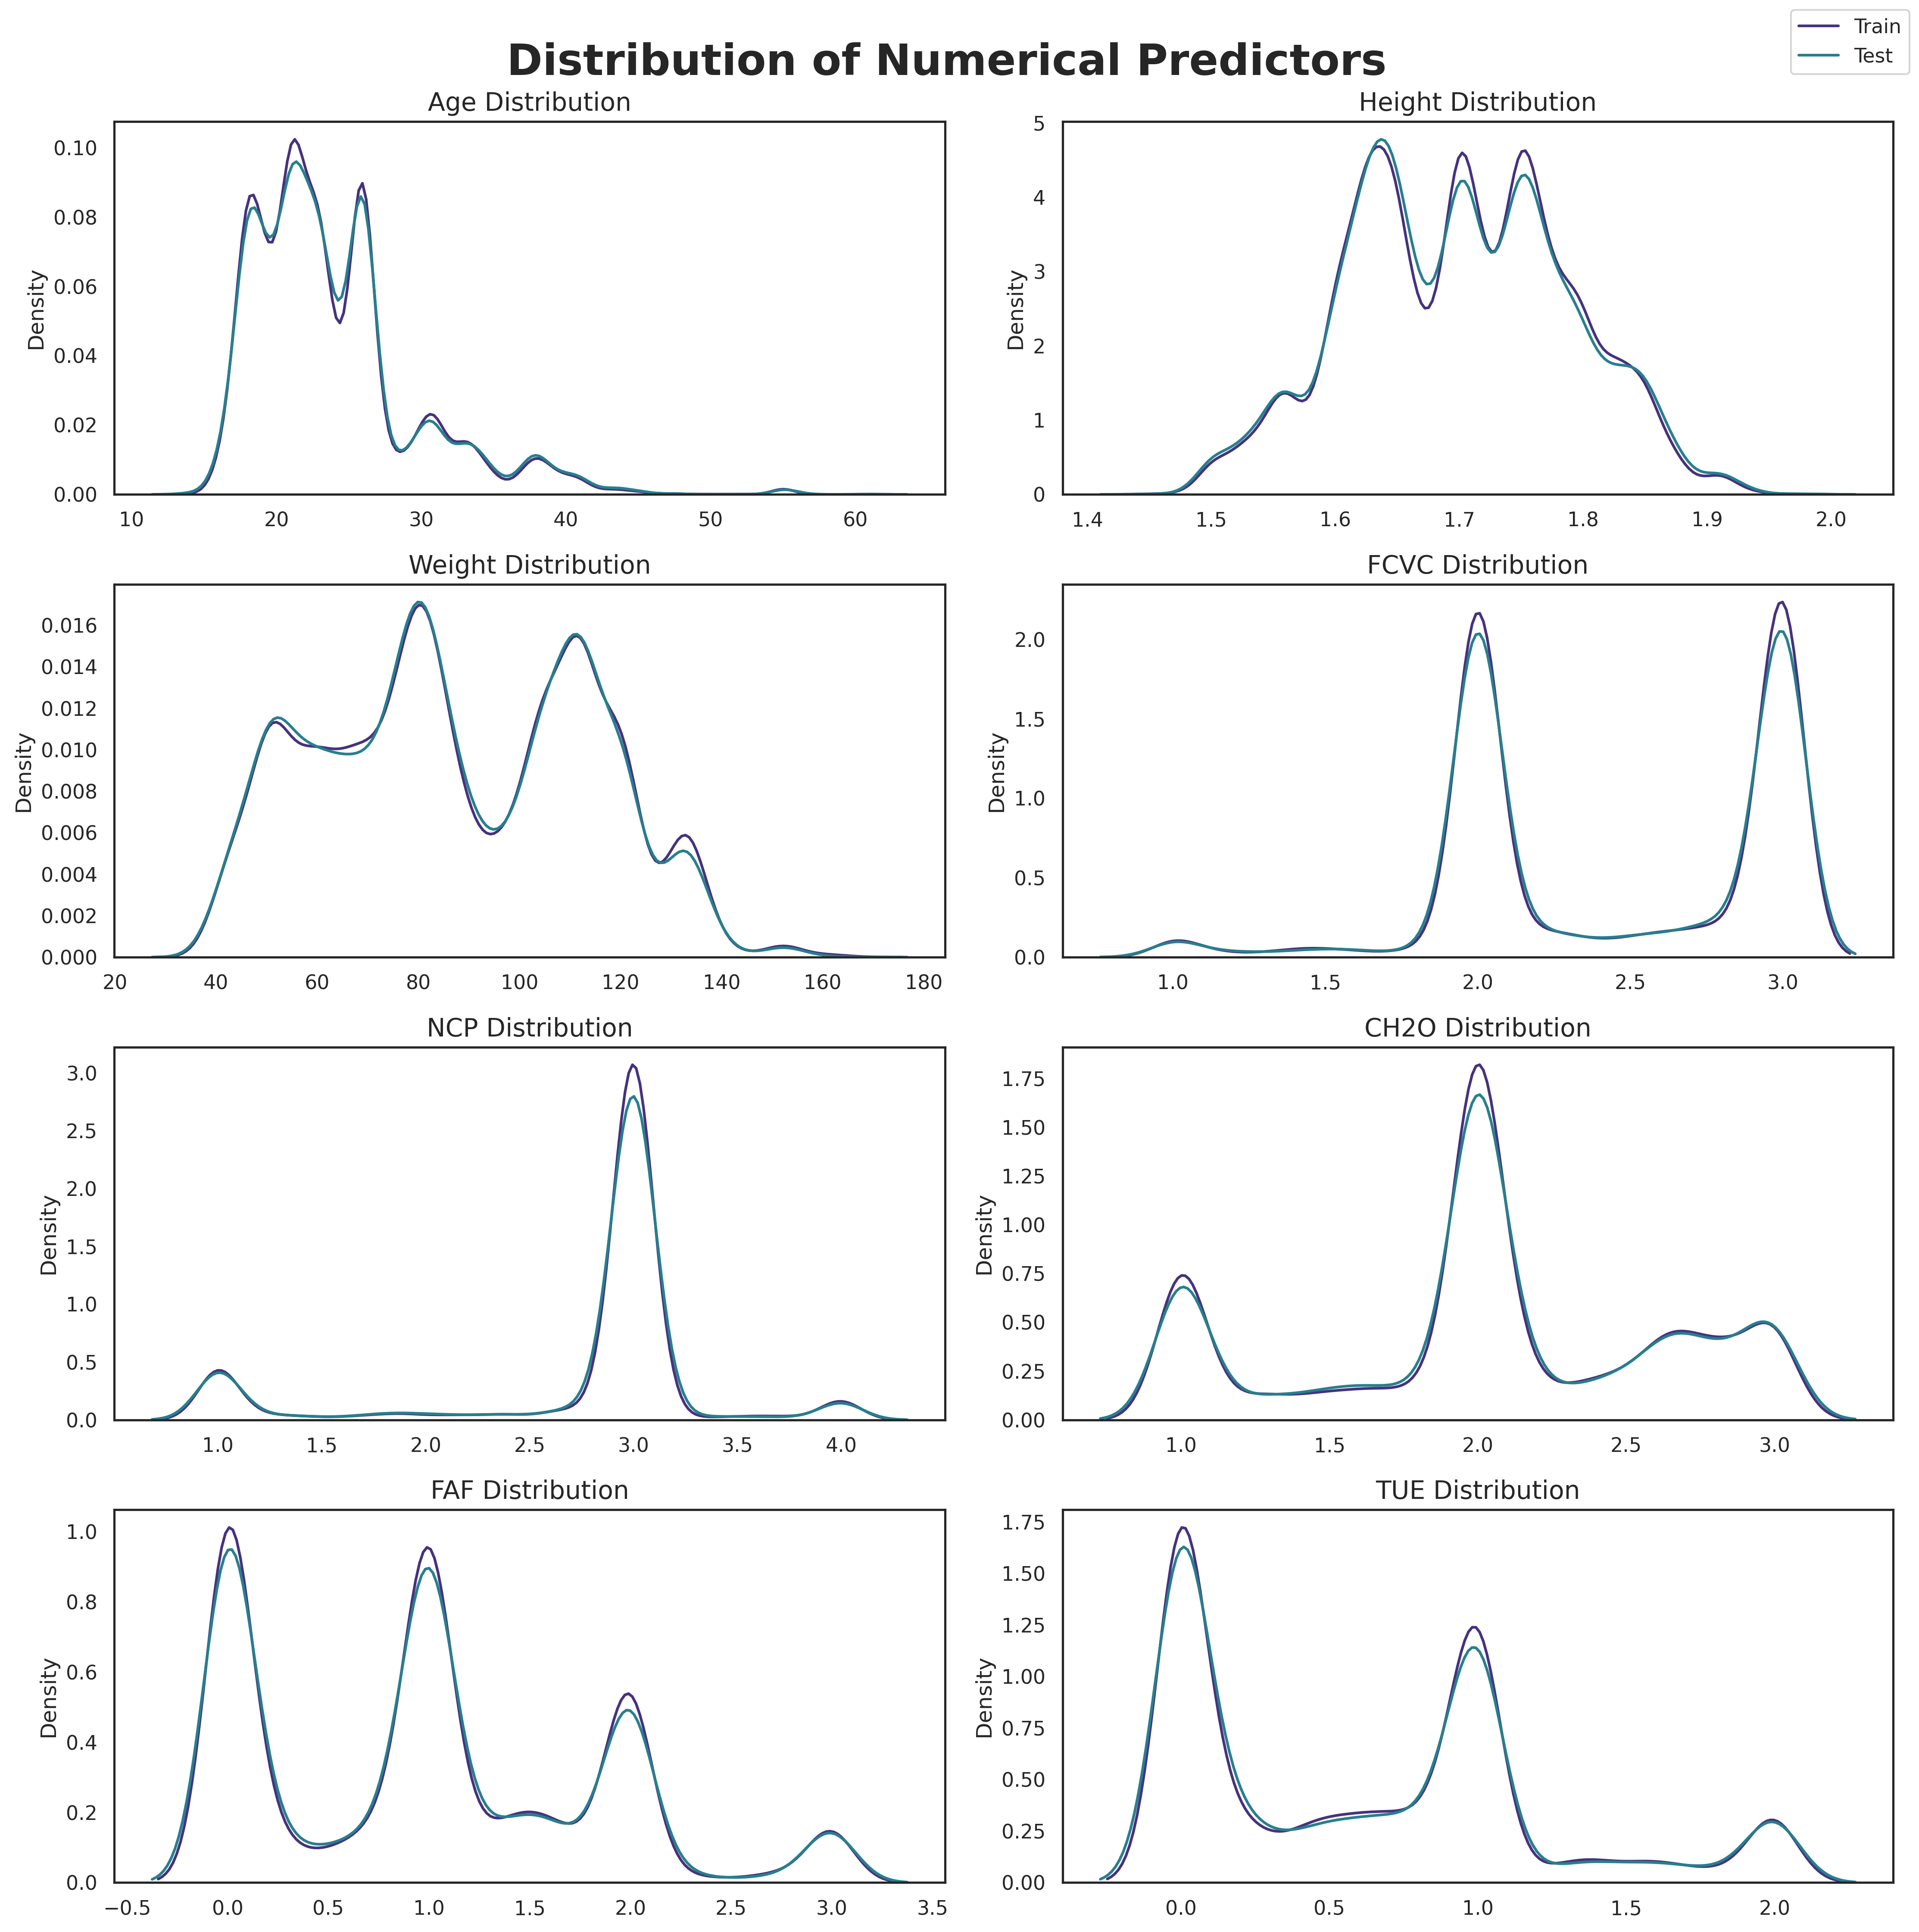

In [21]:
# Visualizing distributions of numerical predictors
fig, ax = plt.subplots(4, 2, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
train_numerical = train.drop(['id', 'Gender', 'family_history_with_overweight', 'FAVC',
                            'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'], axis=1)
features = train_numerical.columns

for i, column in enumerate(features):
        
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Predictors', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

The plots above show the distributions of each numerical predictor for both the train and test datasets. By showing this, we can verify that the train and test datasets have similar attribute distributions. At a glance, we can see that many of the numerical predictors have imbalanced distributions. For example, in 'Age', there are many more individuals between 15 and 30 years old than there are individuals who are older than 30. This may be due to the fact that younger individuals tend to be more technologically savvy and thus were more likely to participate in the online survey. Other imbalanced predictors include 'Weight', 'FCVC', 'NCP', 'CH20', 'FAF', and 'TUE'. For 'Weight', it is interesting to see that many individuals are either roughly 80kg or roughly 110kg, but far fewer individuals are roughly 95kg. This discrepancy can be visualized by the valley between the two majority peaks. Another interesting finding is that in 'FCVC' (frequent consumption of vegetables), many more individuals do in fact consume vegetables. This is intriguing, as the exploration of the categorical predictor 'FAVC' showed us that many individuals also frequently consume high caloric foods. 

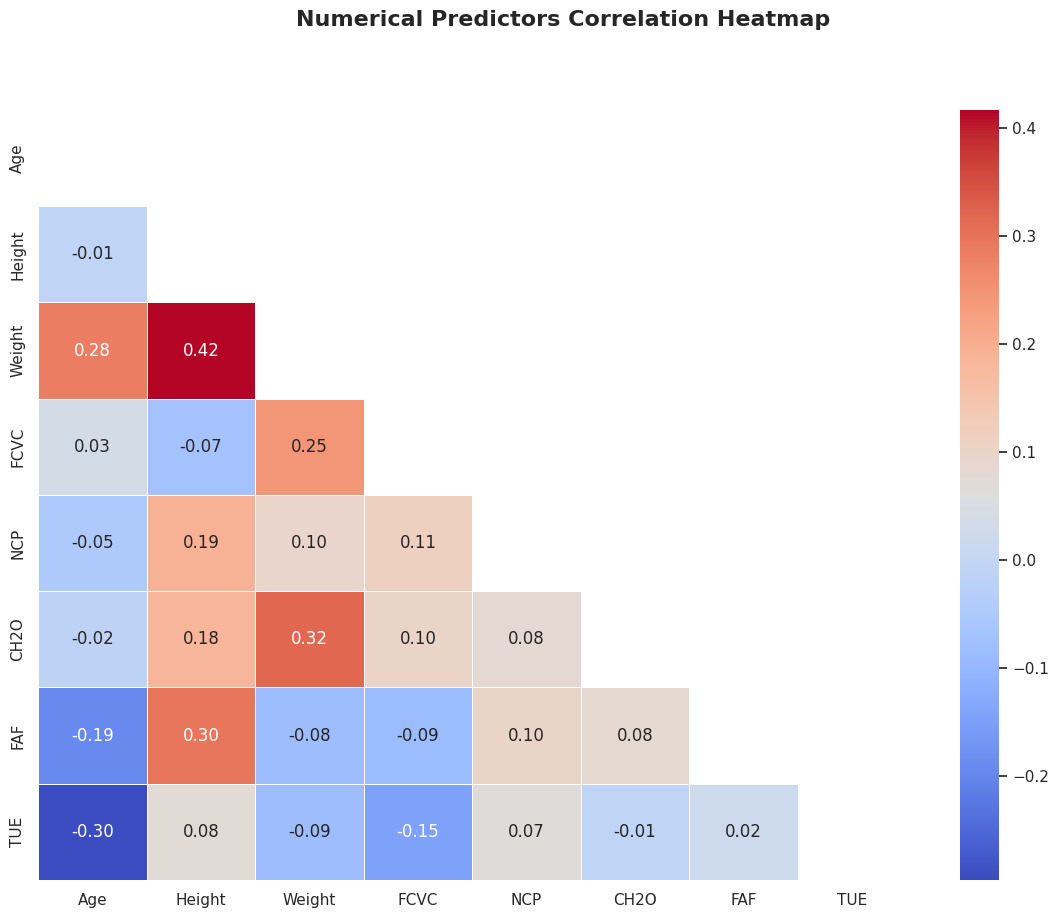

In [22]:
# Plotting correlation heatmap of numerical predictors
plt.figure(figsize=(14,10))
corr=train_numerical.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.suptitle('Numerical Predictors Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

In the heatmap above, we can see that the strongest positive correlation amongst the numerical predictors is a 0.42 correlation between 'Weight' and 'Height'. Relatively speaking, this correlation is not very strong, but the finding is fairly obvious, as taller individuals tend to weigh more than shorter individuals. The second strongest positive correlation is 0.32 between 'CH20' and 'Weight'. This correlation is also not very significant but it is interesting to ponder the loose connection between one's weight and their consumption of water. The strongest negative correlation was -0.30 between 'TUE' (time using technology devices) and 'Age'. This correlation also seems self-explanatory, as one could postulate that younger individuals are more likely to frequently use technology than older individuals. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="5"></a>
# **Data Preprocessing**

This section prepares the datasets for modeling. The following steps have been completed:

- Extracting variable types (continuous/numerical & categorical) 
- Removing the 'id' column from both train and test datasets
- Concatenating (combining) the train and original datasets
- One-hot encoding categorical variables in both train and test datasets
- Separating the predictors (X) and target variable (y)
- Splitting the data into training (80%) and testing (20%) sets

In [23]:
# Extracting variable types from 'train' dataset
# Kudos to Moaz Eldsouky for this code chunk
def get_variable_types(dataframe):
    continuous_vars = []
    categorical_vars = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)

    return continuous_vars, categorical_vars

continuous_vars, categorical_vars = get_variable_types(train)
categorical_vars.remove('NObeyesdad')

The code chunk above (kudos to [Moaz Eldsouky](https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook)!) extracts the variable types from the train dataset. This essentially assigns the variables to either a categorical or continuous (numerical) group. This step is necessary for later converting the categorical variables using one-hot encoding. This chunk also removes the target variable 'NObeyesdad' from the categorical variable group. 

In [24]:
# Concatenating 'train' and 'original' datasets
train = pd.concat([train, original]).drop(['id'], axis=1).drop_duplicates()

# Removing 'id' column from 'test' dataset
test = test.drop(['id'], axis=1)

The code chunk above simply concatenates (combines) the train and original datasets. By combining these datasets, we now have more data to train our model on! Here, we also remove the 'id' column in both train and test sets, as this is not technically a predictor that can help the model. 

In [25]:
# One-hot encoding categorical variables in 'train' and 'test' datasets
train = pd.get_dummies(train, columns = categorical_vars, drop_first = True)
test = pd.get_dummies(test, columns = categorical_vars, drop_first = True)

The one-hot encoding above converts the categorical variables in both train and test datasets into boolean. The original object datatype cannot be used by the model and thus the change to boolean assists this process. 

In [26]:
# Verifying the updated shapes of each dataset
print(f'The shape of the train dataset is: {np.shape(train)}')
print(f'The shape of the test dataset is: {np.shape(test)}')

The shape of the train dataset is: (22845, 24)
The shape of the test dataset is: (13840, 23)


Above, we can verify the updates to the shapes of the train and test datasets. Notably, the train dataset now has more entries, i.e. it now has 22845 entries and previously had 20758. This increase is due to the concatenation of the train and original datasets. Furthermore, we now have more columns. The increase in columns is due to the one-hot encoding.   

In [27]:
# Quickly showing the boolean entries
train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,True,...,False,False,False,False,True,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,False,...,False,False,False,False,False,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,False,...,False,False,False,False,False,True,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,False,...,False,False,False,False,True,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,True,...,False,False,False,False,True,False,False,False,True,False


Above, we can see the work of the one-hot encoding and increased number of columns in the train dataset. Previously, an object type variable, such as 'CALC', had one column and more than two possible responses, i.e. 'Sometimes', 'Frequently', and 'no'. Now, each possible response has its own column (e.g. 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no') and a boolean entry of either True or False.

In [28]:
# Further verifying the changes with .info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22845 entries, 0 to 2110
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 22845 non-null  float64
 1   Height                              22845 non-null  float64
 2   Weight                              22845 non-null  float64
 3   FCVC                                22845 non-null  float64
 4   NCP                                 22845 non-null  float64
 5   CH2O                                22845 non-null  float64
 6   FAF                                 22845 non-null  float64
 7   TUE                                 22845 non-null  float64
 8   NObeyesdad                          22845 non-null  object 
 9   Gender_Male                         22845 non-null  bool   
 10  family_history_with_overweight_yes  22845 non-null  bool   
 11  FAVC_yes                            22845 non-n

Again, we can verify the changes made via preprocessing. All categorical variables (excluding the target variable 'NObeyesdad') have been converted from object datatype to bool datatype. 

In [29]:
# Separating predictors (X) and target (y)
X = train.drop(['NObeyesdad'], axis=1)
y = train['NObeyesdad']

In [30]:
# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Lastly, the two code chunks above split the target variable (y) from the predictors (X) and then use train_test_split to split the data into training (80%) and testing (20%) sets. Having completed this, it is now time to build the LightGBM model! 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="6"></a>
# **Building the Model**

This section leverages [Optuna](https://optuna.org/), an open source hyperparameter optimization framework, to determine the optimal hyperparameter values for the LightGBM model. The code chunk below essentially runs through 50 trials to determine the best parameters for the model and thus obtain the highest possible accuracy. 

In [31]:
# Creating an objective function for Optuna optimization
# This code chunk has been adapted from Moaz Eldsouky's work
def objective(trial, X_train, y_train, X_test, y_test):
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    lgbm_classifier = LGBMClassifier(**params)
    lgbm_classifier.fit(X_train, y_train)
    score = lgbm_classifier.score(X_test, y_test)
    return score

run = 0

if run == 1:
    sampler = optuna.samplers.TPESampler(seed=42)  
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)
    best_params = study.best_params

    print('='*50)
    print(best_params)

Above, we can see the code chunk for the 'objective' function which runs the Optuna trials. Some parameters have already been determined. These include:

- "objective": "multiclass" --> the objective parameter is set to multiclass as this is a multiclass classification problem 
- "metric": "multi_logloss" --> the metric parameter is set to multi_logloss, which is used for for multiclass classification 
- "verbosity": -1 --> this lowers the verbosity (amount of text generated) of the LightGBM model
- "boosting_type": "gbdt" --> this sets the boosting type to traditional gradient boosting decision tree
- "random_state": 42 --> this sets a random state which can be used for reproducing specific results
- "num_class": 7 --> this is only used in multiclass classification 

The remaining parameters will be determined by the 50 trials. Furthermore, each trial uses an independent sampler with a TPE (Tree-Structured Parzen Estimator) algorithm. For each trial, the TPE essentially uses Gaussian Mixture Models to identify the optimal parameter value. The following parameters will be trialed:

- "learning_rate" --> the shrinkage rate, a smaller learning rate may improve accuracy!
- "n_estimators" --> essentially the number of boosting iterations
- "lambda_l1" & "lambda_l2" --> L1 & L2 regularization
- "max_depth" --> this limits the max depth for the tree model
- "colsample_bytree" --> this helps speed up training and potentially deal with over-fitting
- "subsample" --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training
- "min_child_samples" --> the minimal number of data in one tree leaf, helps with over-fitting

Once the trials have been completed, we can set 'run' to equal 0. This will ensure that when the notebook runs again, the trials will not be repeated. This will help reduce the time and size of this project. 

In [32]:
# Recording best parameters from trial above
best_params = {
    "obective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "num_class": 7,
    "learning_rate": 0.014375643091423964,
    "n_estimators": 417,
    "lambda_l1": 0.009576412194321463,
    "lambda_l2": 0.048999237798815196,
    "max_depth": 10,
    "colsample_bytree": 0.6344820729983879,
    "subsample": 0.921085110132749,
    "min_child_samples": 38
}

Above are the recorded best parameters from the 50 trials. These parameters will be fit into the LightGBM model below. 

In [33]:
# Fitting the model with the best parameters!
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

Above, the model is fit onto the training data and then used to make predictions ('y_pred') on the testing data. We can use these predictions to evaluate the model! 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="7"></a>
# **Model Evaluation**

## **Accuracy & Overfitting**

In [34]:
# Checking the accuracy score of the final model
print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.9172685489166119


Above, we can obtain the accuracy of the LightGBM model by comparing its predictions to the expected values from the testing data. Here, we obtain an accuracy of ~0.917. This is pretty good! 

In [35]:
# Checking for overfitting
print('Training set score: {:.4f}'.format(final_model.score(X_train, y_train)))
print('Testing set score: {:.4f}'.format(final_model.score(X_test, y_test)))

Training set score: 0.9501
Testing set score: 0.9173


We can check for overfitting by comparing the accuracies of the model on the training and testing sets. Fortunately there does not appear to be a significant difference between the accuracies and thus we can assume that the model does not overfit the data. 

## **Classification Report**

In [36]:
# Viewing the classification report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.95      0.94       574
      Normal_Weight       0.90      0.90      0.90       677
     Obesity_Type_I       0.92      0.89      0.91       682
    Obesity_Type_II       0.97      0.97      0.97       697
   Obesity_Type_III       1.00      1.00      1.00       878
 Overweight_Level_I       0.81      0.82      0.81       525
Overweight_Level_II       0.83      0.84      0.83       536

           accuracy                           0.92      4569
          macro avg       0.91      0.91      0.91      4569
       weighted avg       0.92      0.92      0.92      4569



Here, we can see the classification report of the final model. The precision column tells us the accuracy of positive predictions, i.e. precision = true positives / (true positives + false positives). The highest precision here is ~1.00 for 'Obesity_Type_III', meaning that the model correctly labeled an individual with Type III obesity almost 100% of the time (the confusion matrix below shows us that it mislabled only 3 times). The lowest precision was ~0.81 for 'Overweight_Level_I'. Next, the recall column tells us the fraction of correctly identified positive predictions, i.e. recall = true positives / (true positives + false negatives). Again, the highest recall was ~1.00 for 'Obesity_Type_III' and the lowest was ~0.82 for 'Overweight_Level_I'. The f1-score essentially measures the harmonic mean of the precision and recall values. Because of this, 'Obesity_Type_III' has the highest f1-score and 'Overweight_Level_I' has the lowest. Lastly, support tells us the number of occurrences of each class in the testing data. So for example, there were 574 occurrences of 'Insufficient_Weight' in the testing data. 

## **Confusion Matrix**

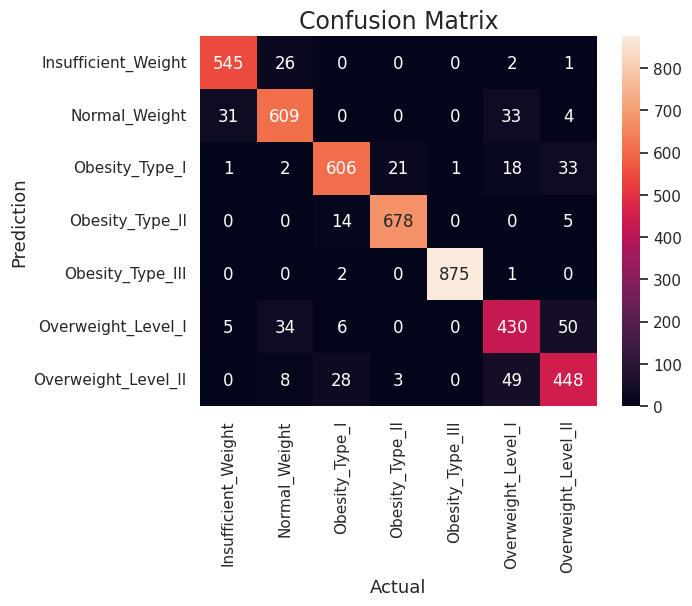

In [37]:
# Viewing the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=final_model.classes_,
            yticklabels=final_model.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

The confusion matrix above provides more insight into how the final model performed. Here, we can see how many times the predicted classes matched the actual classes. For example, for 'Insufficient_Weight', the model correctly labeled 'Insufficient_Weight' cases 545 times. The model incorrectly labeled 'Normal_Weight' cases as 'Insufficient_Weight' 26 times. And the model incorrectly labeled these cases as 'Overweight_Level_I' and 'Overweight_Level_II' twice and once, respectively. As also shown in the classification report, the model performed best on predicting 'Obesity_Type_III' cases. It correctly labeled this class 875 times and only mislabeled the class 3 times. 

## **Feature Importance**

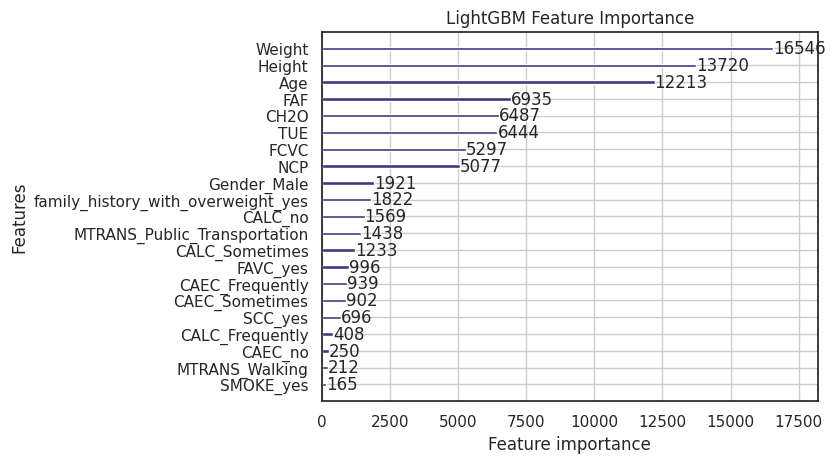

In [38]:
# Visualizing feature importance
plot_importance(final_model, title='LightGBM Feature Importance')
plt.show()

Lastly, we can visualize the feature importance of the LightGBM model. Feature importance essentially tells us which predictors are most useful or impactful at predicting the target variable. The top three important features are 'Weight', 'Height', and 'Age'. Following these features are 'FAF' (physical activity frequency), 'CH20' (daily consumption of water), and 'TUE' (time using technology devices). It is not surprising to see 'Weight' as the most important feature, as one could guess that higher levels of weight must correspond with a higher likelihood of obesity or overweight. It is also likely that 'Height' (which has a 0.42 correlation with 'Weight') may increase with 'Weight' and thus is a significant feature. We can also deduce that as 'Age' increases, the risk of obesity or overweight may also increase. 

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#9" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="8"></a>
# **Kaggle Submission**

This section applies the predictions made by the final model to the Kaggle 'sample_submission' dataset. A final submission dataset is created and then uploaded to Kaggle for competition scoring. 

In [39]:
# Making final predictions on the test set
predictions = final_model.predict(test)

In [40]:
# Importing Kaggle 'sample_submission' dataset
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

In [41]:
# Applying final predictions to submission dataset
submission['NObeyesdad'] = predictions
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [42]:
# Creating .csv file for submissions and scoring
run = 0

if run == 1:
    submission.to_csv('submission.csv', index=False)

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="9"></a>
# **Conclusion**

This project was completed as part of Kaggle's [Multi-Class Prediction of Obesity Risk](https://www.kaggle.com/competitions/playground-series-s4e2/overview) competition and as part of a final project for the 'Data Mining Project' course in CU Boulder's MS-DS program. Two datasets were used, i.e. 'Obesity or CVD risk' (the original data) and the Kaggle data (synthetic data generated from the original data). 

Exploratory data analysis was used on the training data. From this, it was discovered that 73% of individuals were at least overweight. Furthermore, 82% of the subject population had a family member who was overweight, and 91.4% of individuals reported to frequently consume high caloric foods. Statistics such as these suggest that obesity and overweight are prevalent issues that may be exacerbated by diet and habit. The exploratory data analysis also found a relatively strong positive correlation between 'Weight' and 'Height' of 0.42. This appeared to be self-explanatory, as when an individual's height increases, their weight may likely increase as well. There was also a negative correlation between 'Age' and 'TUE' (time using technology devices) of -0.30. This may suggest that younger individuals are more likely to spend more time using technology than older individuals. 

The data was preprocessed and prepared for modeling by converting all categorical variables (object datatype) into boolean by using a one-hot encoder. Afterwards, the original and synthetic datasets were concatenated and then split into training (80%) and testing (20%) sets. The parameters of the LightGBM model were trialed via the use of Optuna. 50 trials were conducted to obtain the optimal parameters. 

The final LightGBM model yielded an accuracy score of ~91.7%. Furthermore, the model did not appear to overfit the data, as the training set accuracy score (0.9501) did not appear to differ significantly from the testing set accuracy score (0.9173). Both a classification report and confusion matrix suggested that the model performed best when predicting the 'Obesity_Type_III' class. Precision for this class was almost 100%, with 875 correct predictions and only 3 incorrect predictions. The model appeared to perform the worst when predicting the 'Overweight_Level_I' class. Here, the precision was only 81%, with 430 correct predictions and 95 incorrect predictions. Lastly, a feature importance plot showed that the three most important predictors were 'Weight', 'Height', and 'Age'. There is a chance that these three predictors are somewhat linked or correlated, as when individuals grow older, they tend to increase in both height and weight. Regardless, 'Weight' is likely the most important predictor simply due to the fact that individuals with greater weights are more likely to be overweight or obese. Other important predictors were 'FAF' (physical activity frequency), 'CH20' (daily consumption of water), and 'TUE' (time using technology devices). From this, one could postulate that increased physical activity and consumption of water may be beneficial in maintaining a healthy weight. Furthermore, increased time using technology devices may result in a more sedentary lifestyle, thus contributing to a greater chance of becoming overweight or obese. 

In conclusion, I hope that this project was informative. This project provided me with an excellent opportunity to learn how to build and utilize the LightGBM model. If you enjoyed this project, please feel free to give it an upvote! 

<a id="R"></a>
# **References**

- https://www.kaggle.com/competitions/playground-series-s4e2/overview
- https://pubmed.ncbi.nlm.nih.gov/35584732/
- https://www.worldobesity.org/resources/resource-library/world-obesity-atlas-2022
- https://www.mdpi.com/2072-6643/14/20/4253
- https://github.com/microsoft/LightGBM
- https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
- https://www.kaggle.com/code/ddosad/ps4e2-visual-eda-lgbm-obesity-risk
- https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook
- https://www.thelancet.com/journals/langlo/article/PIIS2214-109X(20)30311-9/fulltext
- https://optuna.org/